In [1]:
# %env TF_FORCE_GPU_ALLOW_GROWTH=true
# %matplotlib widget
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import tensorflow as tf
from tensorflow import keras
from collections import Counter
from tensorflow import keras
from keras.preprocessing.sequence import skipgrams
from keras.layers import Dense, Embedding, LSTM, TimeDistributed, Input, Bidirectional, TextVectorization, CategoryEncoding
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import re
import json
import pandas as pd

### Prédéfinir la taille de séquence de TextVectorization 
#### (avec le nombre de caractères dans l'article le plus long)

In [2]:
# utiliser la colonne "Text" sans espace dans le csv
texts = pd.read_csv('../corpus/SB_Tokenization1_Wrk_佳威 - SB_Tokenization1_Wrk.csv', usecols = ['Text'])['Text'].str.strip().tolist()
distribution_longueur_text = [len(t) for t in texts]
print(distribution_longueur_text)
seq_len = len(max(texts, key=len))
print(seq_len)

[1011, 1074, 1313, 254, 368, 426, 432, 479, 220, 252, 290, 301, 320, 321, 332, 368, 389, 423, 427, 441, 444, 294, 299, 301, 313, 323, 330, 333, 337, 351, 358, 378, 398, 419, 424, 493, 271, 283, 352, 375, 387, 286, 292, 295, 309, 324, 440, 449, 462, 479, 486, 495]
1313


### Préparer le co-corpus-train pour l'entraînement avec le corpus Kyoto

In [3]:
# fonction qui filtre les textes seleon la taille
# prendre les textes dont la taille est entre la taille de l'article le plus court et la taille de l'article le plus long
def corpus_copilote(c_en_listes):
    c_filtre = [ e for e in c_en_listes if 200 < len(e.split(' ')) < seq_len]
    return c_filtre 

In [4]:
# traiter le corpus de l'université de kyoto
from random import shuffle
s_c = open('../corpus/annotation-train_v4.txt').read()
s_c = s_c.split('\n')
s_c = corpus_copilote(s_c)
shuffle(s_c)
print(len(s_c))

58


In [5]:
# fonction qui garantit pour le corpus test il y un article par année
def for_test(s):
    new_s = []
    s_test = []
    no_repeat = []
    for e in s :
        if e[:4] not in no_repeat and len(s_test) <= 5 :
            no_repeat.append(e[:4])
            s_test.append(e)
        else:
            new_s.append(e)
    return new_s, s_test
        

In [6]:
# constituer le corpus train/dev/test
s = open('../corpus/texte_shenbao_label_v2.txt').read()
s = s.split('\n')
shuffle(s)
s_train, s_test = for_test(s)
shuffle(s_train)
s, s_dev = s_train[15:],s_train[:15]
# ajouter le co-corpus
s = s + s_c[:20]
# ou n'utiliser que le corpus Shenbao
#s = s
shuffle(s)

In [7]:
print(len(s))

52


### Préparer les données avec les données de Shenbao prétraitées

In [8]:
# fonction qui permet de séparer les caractères et les étiquettes en deux listes pour un seul texte
def get_xy(s):
    s = re.findall('(.)/(.)', s)
    if s:
        s = np.array(s)
        return list(s[:,0]), list(s[:,1])

In [9]:
# fonction qui parcourt le corpus en utilisant la fonction get_xy()
def corpus_data_label(corpus, data, label):
    for i in corpus:
        x = get_xy(i)
        if x:
            data.append(x[0])
            label.append(x[1])
    return data, label

In [10]:
# fonction qui joint tous les caractères pour les passer dans la couche TextVectorization
def joins_char(list_char):
    return ["".join(e) for e in list_char]

In [11]:
# fonction qui traite toutes les données, les données, les réponses et l'année
def all_data(t_a):
    annee = []
    texte = []
    # séparer l'année avec le texte
    for e in t_a:
        if ":" in e:
            texte.append(e.split(" : ")[1])
            annee.append(e.split(" : ")[0])
    data, label = corpus_data_label(texte, [], [])
    chaine_sans_espace = joins_char(data)
    # obtenir la taille de l'article pour savoir combien de fois qu'on répète l'année 
    # la seq_len sera pris en compte pour garantir la largeur de tous les tenseurs soit égale
    # si la taille de l'article est supérieur à seq_len, il faut couper le vecteur en fonction de la valeur de seq_len
    l_articles = [ len(l) if len(l) < seq_len else seq_len for l in chaine_sans_espace]
    annee_longueur = list(zip(annee, l_articles))
    label_longueur = list(zip(label, l_articles))
    return annee_longueur, data, label_longueur, chaine_sans_espace

### Séparare le corpus en textes, réponses, année

In [12]:
annee_train, data, label, prepare_text_train = all_data(s)
annee_dev, data_dev, label_dev, prepare_text_dev = all_data(s_dev)
annee_test, data_test, label_test, prepare_text_test = all_data(s_test)
# garantir que lot de l'année ait la même taille que le lot de données
assert len(annee_train) == len(prepare_text_train)
assert len(annee_dev) == len(prepare_text_dev)
assert len(annee_test) == len(prepare_text_test)

In [13]:
print(annee_test[:5])
print(prepare_text_test[:5])

[('1907', 479), ('1887', 310), ('1877', 299), ('1897', 265), ('1872', 1005)]
['某洋商前裴少村不交股銀等情陳明府判裴限交楊文行到案昨又傳訊裴稱楊已全家搬逃無從交案若該洋人苟有實在營業商人仍願照議交股本四千兩原告稱裴延緩日久耗費不貲請堂上照議罰銀二千兩中西官會判裴另行覔保前保人旣求退保准予所請法新租界某日人所開學堂之學生葛人龍胡槐卿在呂班路覽馬雨山陸庭華擕兩女孩同行以其情節可疑交捕一併拘訊馬稱同居某姓欲領養媳由小的作伐將兩女領往觀看有孩母可証質之孩母張王氏所供相同官判兩女寄堂馬陸仍押捕房著張王氏之夫到案訊核三十六個黨阿堂在碼頭竊周怡昌烟士十只旋有該黨林阿五向周索酧洋五元允交賊贓經招商局巡了頭目沈某查知林屢次冐充巡丁索昨卽將林及戴桂林王阿三送捕解究官判戴王押候林交保交到阿堂再訊周順生將已許婚之姪女采英與林坤泉之子爲媒等情已誌前報茲捕房續將女母周陳氏拘訊據供去年將女過寄林姓並未許婚官判順生開釋氏押候將女交案再訊高恆山梁春三投案禀稱假興聖街源發客棧前晚出外回棧詎房中箱籠已被割破竊去衣服洋元將店主李永生棧司徐平和扭究官判徐開釋李交保限三天交贓馬夫李阿炳快馬違章爲捕頭親見飭捕拘訊官判罰洋四十元夏姚生駕駛無捐照之馬車爲捕解究判罰洋二十元', '鄞邑朱友笙大令病殁縣署昨已錄報兹悉初四日未刻大殮道府二憲及牙厘局憲均往拜喪新任趙邑尊紅諭未到不知何日接篆署中一切公事刻委捕廳暫行兼理鄉人某甲行至西門外某雜貨店需買零星物多件店夥以所需各物尚待包紥囑其暫坐少待命學徒遞茶給烟不意鄉人茶未飮畢猝然倒地氣絶一時無可灌救店主大爲張皇幸有近處舟子認識趕卽報知其家其家人亦知死由急症别無他故不與爲難當就近處曠地搭棚棺殮載之以歸郡廟開光日期前已錄報兹悉工雖告竣尚虧多金無可措辦擬將發售關牒之金錢以抵所虧轉念買牒有弛禁令改定開光勝會圖代充關牒此亦無可設法不得不如是也寍郡自八月下旬得雨後迄今點滴無沾畫則日色晴明夜則星光皎潔春花有碍百物枯燥不特易招火災人亦多臥病者不知何日得沛甘霖以甦民困也', '杭垣望仙橋一帶爲市面最盛之處天氣近甚燥烈十一日申刻橋東之鳳陽樓羊湯飯店以遺燼復燃延入堆柴之房火輒冲上屋頂撲救不及勢遂燎原時又西風大作火卽撲過橋西之大成烟店水龍聞警畢集大小文武各員亦以次馳到督飭水龍盡力施救四路拔開火道直至酉初火勢方熄計被災者一十餘家

In [14]:
# mettre les 0 après l'année, le nombre de 0 égale à la taille de l'aticle si elle est inférieure à 
# seq_len, sinon le nombre de 0 doit égaler à seq_len
annee_train = np.array([np.concatenate([np.repeat(np.array(int(s[0])), s[1]),np.zeros(seq_len-s[1])]) for s in annee_train]).reshape(-1,seq_len)
annee_dev = np.array([np.concatenate([np.repeat(np.array(int(s[0])), s[1]),np.zeros(seq_len-s[1])]) for s in annee_dev]).reshape(-1,seq_len)
annee_test = np.array([np.concatenate([np.repeat(np.array(int(s[0])), s[1]),np.zeros(seq_len-s[1])]) for s in annee_test]).reshape(-1,seq_len)


In [15]:
print(annee_train.shape )
print(annee_dev.shape)
print(annee_test.shape)
print(len(prepare_text_test[4]))
import collections
counter = collections.Counter(annee_test[4])
print(counter)

(52, 1313)
(15, 1313)
(5, 1313)
1005
Counter({1872.0: 1005, 0.0: 308})


### TextVectorization pour les données

In [16]:
# définir la couche de Textvectorization
def vecteur_data(dataset, seq_length):
    tv=TextVectorization(standardize=None, 
                           split="character", 
                           output_sequence_length=seq_length, 
                           output_mode='int')
    tv.adapt(dataset)
    return tv
tv = vecteur_data(prepare_text_train, seq_len)


Metal device set to: Apple M1


2023-05-20 18:12:44.969215: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-20 18:12:44.969314: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-05-20 18:12:45.002691: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-20 18:12:45.046649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [17]:
# transformer les caractères en vecteurs
X_train = tv(prepare_text_train)
X_dev = tv(prepare_text_dev)
X_test = tv(prepare_text_test)

In [18]:
print(len(tv.get_vocabulary()))

3038


### Couche Embedding pré-entrainée

In [19]:
embeddings_index = {}
with open('../corpus/Wiki_300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [20]:
# mettre les valeurs des vecteurs dans une matrice
# pour mettre dans la couche Embedding
embedding_matrix = np.zeros((len(tv.get_vocabulary()), 300))
for i, word in enumerate(tv.get_vocabulary()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### Catégorisation pour les réponses

In [21]:
dic = {"b":1, "e":2, "m":3, "y":4, "s":5}
categorical = CategoryEncoding(num_tokens=6, output_mode="one_hot")
Y_train = np.array([categorical(np.concatenate((np.array([dic[e] for e in l[0][:seq_len]]),np.zeros(seq_len-l[1])), axis=None)) for l in label]).reshape((-1,seq_len,6))
Y_dev = np.array([categorical(np.concatenate((np.array([dic[e] for e in l[0][:seq_len]]),np.zeros(seq_len-l[1])), axis=None)) for l in label_dev]).reshape((-1,seq_len,6))
Y_test = np.array([categorical(np.concatenate((np.array([dic[e] for e in l[0][:seq_len]]),np.zeros(seq_len-l[1])), axis=None)) for l in label_test]).reshape((-1,seq_len,6))
print(Y_train.shape)
print(Y_dev.shape)
print(Y_test.shape)

(52, 1313, 6)
(15, 1313, 6)
(5, 1313, 6)


In [22]:
print(X_train.shape)
print(annee_train.shape)
print(X_dev.shape)
print(Y_train.shape)

(52, 1313)
(52, 1313)
(15, 1313)
(52, 1313, 6)


## Modèle sans l'information de l'année

In [23]:
def build_model_1_input(word_size, maxlen, emb_matrix):
    sequence = Input(shape=(maxlen,), dtype='int32')
    # utilise la couche embeddings pré-entraînée
    if emb_matrix.any():
        embedded = Embedding(len(tv.get_vocabulary()), 300, weights=[emb_matrix], input_length=maxlen, mask_zero=True, trainable=False)(sequence)
    else:
        embedded = Embedding(len(tv.get_vocabulary()), 128, input_length=maxlen, mask_zero=True)(sequence)
    blstm = Bidirectional(LSTM(64, return_sequences=True), merge_mode='sum')(embedded)
    output = TimeDistributed(Dense(6, activation='softmax'))(blstm)
    model = Model(inputs=sequence, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    return model

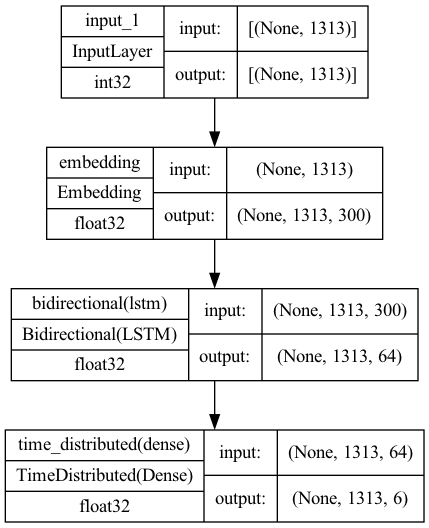

In [24]:
m_simple = build_model_1_input(128, seq_len, embedding_matrix)
dot_img_file = 'model_simple.png'
keras.utils.plot_model(m_simple, show_dtype=True, show_shapes=True, show_layer_names=True, to_file=dot_img_file,show_layer_activations=True)

In [25]:
batch_size = 10
history = m_simple.fit(X_train, Y_train, validation_data=(X_dev, Y_dev), batch_size=batch_size, epochs=20)

Epoch 1/20


2023-05-20 18:12:49.878234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:12:50.278676: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}

	while inferring type of node 'cond_42/output/_19'
2023-05-20 18:12:50.282023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:12:50.282089: I tens

6/6 [==============================] - ETA: 0s - loss: 0.5723 - categorical_accuracy: 0.5083

2023-05-20 18:13:38.965013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:13:39.212512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:13:39.212556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 64s 8s/step - loss: 0.5723 - categorical_accuracy: 0.5083 - val_loss: 0.4456 - val_categorical_accuracy: 0.4265
Epoch 2/20
6/6 [==============================] - 5s 905ms/step - loss: 0.4193 - categorical_accuracy: 0.6692 - val_loss: 0.3770 - val_categorical_accuracy: 0.4348
Epoch 3/20
6/6 [==============================] - 5s 920ms/step - loss: 0.3814 - categorical_accuracy: 0.6720 - val_loss: 0.3382 - val_categorical_accuracy: 0.4460
Epoch 4/20
6/6 [==============================] - 5s 909ms/step - loss: 0.3592 - categorical_accuracy: 0.6836 - val_loss: 0.3377 - val_categorical_accuracy: 0.4616
Epoch 5/20
6/6 [==============================] - 5s 904ms/step - loss: 0.3428 - categorical_accuracy: 0.6911 - val_loss: 0.3457 - val_categorical_accuracy: 0.4539
Epoch 6/20
6/6 [==============================] - 6s 932ms/step - loss: 0.3299 - categorical_accuracy: 0.7004 - val_loss: 0.3346 - val_categorical_accuracy: 0.4652
Epoch 7/20
6/6 [=============

## Modèle avec l'information de l'année qui passe avant la couche bi-lstm

In [26]:
def build_model_2_inputs(maxlen, emb_matrix):
    sequence = Input(shape=(maxlen,), dtype='int32')
    if emb_matrix.any():
        embedded = Embedding(len(tv.get_vocabulary()), 300, weights=[emb_matrix], input_length=maxlen, mask_zero=True, trainable=False)(sequence)
    else:
        embedded = Embedding(len(tv.get_vocabulary()), 128, input_length=maxlen, mask_zero=True)(sequence)
    year = Input(shape=(maxlen,), dtype='int32')
    embedded_year = Embedding(7, 7, input_length=maxlen, mask_zero=True)(year)
    concat = tf.keras.layers.Concatenate()([embedded, embedded_year])
    blstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3), merge_mode='sum')(concat)
    output = TimeDistributed(Dense(6, activation='softmax'))(blstm)
    model = Model(inputs=[sequence,year], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    return model 

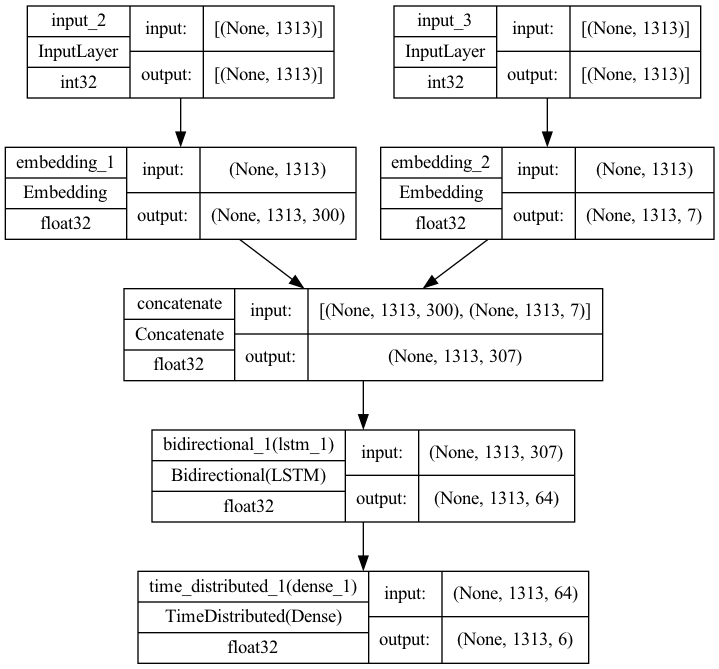

In [27]:
m = build_model_2_inputs(seq_len, embedding_matrix)
dot_img_file_1 = 'model_annee_lstm.png'
keras.utils.plot_model(m, show_dtype=True, show_shapes=True, show_layer_names=True, to_file=dot_img_file_1,show_layer_activations=True)

In [28]:
Y_train.shape

(52, 1313, 6)

#### entraînement du modèle

In [29]:
batch_size = 10
history = m.fit([X_train,annee_train], Y_train, validation_data=([X_dev,annee_dev], Y_dev), batch_size=batch_size, epochs=20)

Epoch 1/20


2023-05-20 18:15:45.323726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:15:45.862797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:15:45.969094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:15:52.173649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:15:52.281153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.6496 - categorical_accuracy: 0.4082

2023-05-20 18:16:36.019348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:16:36.330435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:16:36.330556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 67s 8s/step - loss: 0.6496 - categorical_accuracy: 0.4082 - val_loss: 0.4692 - val_categorical_accuracy: 0.4248
Epoch 2/20
6/6 [==============================] - 6s 1s/step - loss: 0.4386 - categorical_accuracy: 0.6643 - val_loss: 0.4343 - val_categorical_accuracy: 0.4263
Epoch 3/20
6/6 [==============================] - 6s 971ms/step - loss: 0.4004 - categorical_accuracy: 0.6693 - val_loss: 0.3701 - val_categorical_accuracy: 0.4356
Epoch 4/20
6/6 [==============================] - 6s 970ms/step - loss: 0.3857 - categorical_accuracy: 0.6665 - val_loss: 0.3489 - val_categorical_accuracy: 0.4454
Epoch 5/20
6/6 [==============================] - 6s 990ms/step - loss: 0.3646 - categorical_accuracy: 0.6787 - val_loss: 0.3608 - val_categorical_accuracy: 0.4466
Epoch 6/20
6/6 [==============================] - 6s 986ms/step - loss: 0.3539 - categorical_accuracy: 0.6833 - val_loss: 0.3552 - val_categorical_accuracy: 0.4520
Epoch 7/20
6/6 [================

### Modèle avec l'information de l'année qui passe après la couche bi-lstm

In [30]:
def build_model_2_inputs_v2(maxlen=seq_len, emb_year_size=7, lstm_size=64, lr=0.02, emb_matrix=embedding_matrix):
    sequence = Input(shape=(maxlen,))
    if emb_matrix.any():
        embedded = Embedding(len(tv.get_vocabulary()), 300, weights=[emb_matrix], input_length=maxlen, mask_zero=True, trainable=False)(sequence)
    else:
        embedded = Embedding(len(tv.get_vocabulary())+1, 128, input_length=maxlen, mask_zero=True)(sequence)
    year = Input(shape=(maxlen,))
    embedded_year = Embedding(7, emb_year_size, input_length=maxlen, mask_zero=True)(year)
    blstm = Bidirectional(LSTM(lstm_size, return_sequences=True, dropout=0.3), merge_mode='sum')(embedded)
    concat = tf.keras.layers.Concatenate()([blstm, embedded_year])
    output = TimeDistributed(Dense(6, activation='softmax'))(concat)
    model = Model(inputs=[sequence,year], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['categorical_accuracy'])
    return model

#### le tuner pour le modèle où l'information de l'année passe après la couche LSTM

In [31]:
"""
from keras_tuner import HyperParameters,RandomSearch,Hyperband
def hypermodel(hp: HyperParameters)-> keras.Model:
    lr = hp.Float("lr", min_value=0.0001,
                  max_value=0.05)
    e_year_size = hp.Int("emb_year_size", min_value=3, max_value=16)
    l_size = hp.Int("lstm_size", min_value=24, max_value=70)
    return build_model_2_inputs_v2( seq_len, e_year_size, l_size, lr)
"""

'\nfrom keras_tuner import HyperParameters,RandomSearch,Hyperband\ndef hypermodel(hp: HyperParameters)-> keras.Model:\n    lr = hp.Float("lr", min_value=0.0001,\n                  max_value=0.05)\n    e_year_size = hp.Int("emb_year_size", min_value=3, max_value=16)\n    l_size = hp.Int("lstm_size", min_value=24, max_value=70)\n    return build_model_2_inputs_v2( seq_len, e_year_size, l_size, lr)\n'

In [32]:
"""
tuner = RandomSearch(
    hypermodel=hypermodel,
    objective="val_categorical_accuracy",
    max_trials=7,
    project_name="segmentation"
)"""

'\ntuner = RandomSearch(\n    hypermodel=hypermodel,\n    objective="val_categorical_accuracy",\n    max_trials=7,\n    project_name="segmentation"\n)'

In [33]:
#tuner.search_space_summary()

In [34]:
#tuner.search([X_train, annee_train], Y_train, shuffle=True, validation_data=([X_dev,annee_dev], Y_dev), epochs=20,callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

In [35]:
#hp = tuner.get_best_hyperparameters(-1)[0]
#print(hp.get_config()['values'])

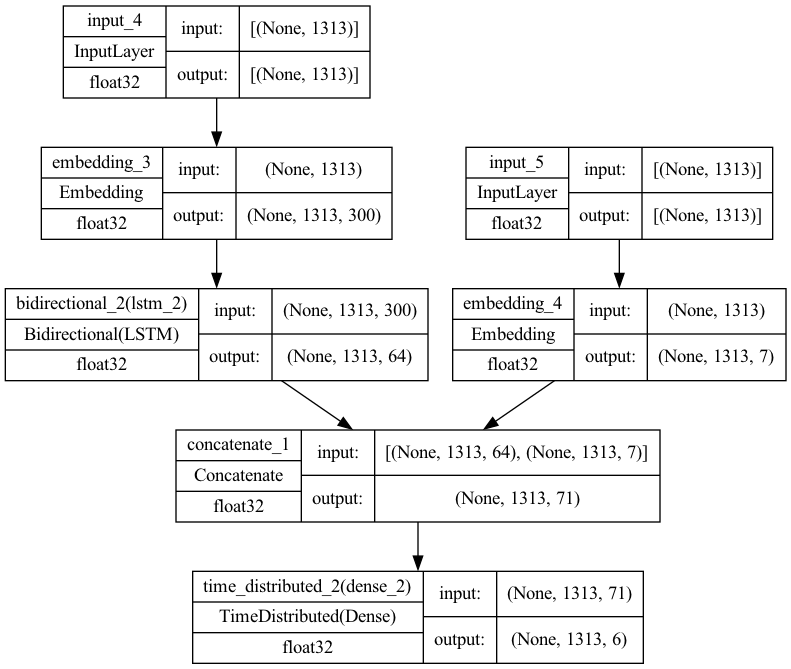

In [36]:
# utiliser les hyper-paramètres par défaut défnies dans la fonction build_model_2_inputs_v2()
m2 = build_model_2_inputs_v2()
# utiliser les hyper-paramètres trouvées par le tuner
#m2_tunning = build_model_2_inputs_v2(seq_len,hp['emb_year_size'],hp['lstm_size'], hp['lr'], embedding_matrix)
dot_img_file_2 = 'model_lstm_annee.png'
keras.utils.plot_model(m2, show_dtype=True, show_shapes=True, show_layer_names=True, to_file=dot_img_file_2,show_layer_activations=True)

#### entraînement du modèle

In [37]:
batch_size = 10
history = m2.fit([X_train,annee_train], Y_train, validation_data=([X_dev,annee_dev], Y_dev), batch_size=batch_size, epochs=20)

Epoch 1/20


2023-05-20 18:18:45.663839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:18:46.186690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:18:46.297598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:18:52.576369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:18:52.704742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.5486 - categorical_accuracy: 0.5177

2023-05-20 18:19:36.621952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:19:36.896676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:19:36.954039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 67s 8s/step - loss: 0.5486 - categorical_accuracy: 0.5177 - val_loss: 0.3981 - val_categorical_accuracy: 0.4335
Epoch 2/20
6/6 [==============================] - 6s 1s/step - loss: 0.3887 - categorical_accuracy: 0.6682 - val_loss: 0.3266 - val_categorical_accuracy: 0.4414
Epoch 3/20
6/6 [==============================] - 6s 1s/step - loss: 0.3826 - categorical_accuracy: 0.6710 - val_loss: 0.3311 - val_categorical_accuracy: 0.4392
Epoch 4/20
6/6 [==============================] - 7s 1s/step - loss: 0.3531 - categorical_accuracy: 0.6826 - val_loss: 0.3347 - val_categorical_accuracy: 0.4429
Epoch 5/20
6/6 [==============================] - 6s 1s/step - loss: 0.3375 - categorical_accuracy: 0.6920 - val_loss: 0.3348 - val_categorical_accuracy: 0.4516
Epoch 6/20
6/6 [==============================] - 6s 1s/step - loss: 0.3180 - categorical_accuracy: 0.7072 - val_loss: 0.3278 - val_categorical_accuracy: 0.4666
Epoch 7/20
6/6 [============================

### Évaluer les modèles

In [38]:
# score du premier modèle, la concat se fait avant la couche LSTM
score = m.evaluate([X_test,annee_test], Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1/1 [==============================] - 1s 596ms/step - loss: 0.4363 - categorical_accuracy: 0.4932
Test loss: 0.4362538456916809
Test accuracy: 0.49321457743644714


In [39]:
# score du deuxième modèle, la concat se fait après la couche LSTM
score = m2.evaluate([X_test,annee_test], Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1/1 [==============================] - 0s 488ms/step - loss: 0.4566 - categorical_accuracy: 0.5242
Test loss: 0.45664873719215393
Test accuracy: 0.5241730213165283


In [40]:
# score du deuxième modèle avec le tuning
"""
score = m2_tunning.evaluate([X_test,annee_test], Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])"""

"\nscore = m2_tunning.evaluate([X_test,annee_test], Y_test, verbose=1)\nprint('Test loss:', score[0])\nprint('Test accuracy:', score[1])"

In [41]:
# score du modèle simple
score = m_simple.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1/1 [==============================] - 1s 934ms/step - loss: 0.4575 - categorical_accuracy: 0.4949
Test loss: 0.4575099050998688
Test accuracy: 0.49491095542907715


### Traiter la sortie des modèles

In [42]:
pred = m2.predict([X_test,annee_test])

2023-05-20 18:21:49.817324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:21:50.090534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 18:21:50.149519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 8s 8s/step


In [43]:
print(pred[0][:len(prepare_text_test[0])])

[[3.52839270e-05 1.51295349e-01 1.55060574e-01 2.80789565e-02
  2.43093278e-02 6.41220570e-01]
 [1.69161945e-06 8.40362430e-01 1.32166604e-02 1.11311944e-02
  1.03511731e-04 1.35184512e-01]
 [6.19985367e-05 6.62200898e-02 7.88742065e-01 5.77147119e-03
  9.14272014e-03 1.30061671e-01]
 ...
 [1.25499182e-05 5.48145354e-01 8.40108693e-02 1.35028422e-01
  6.69552712e-03 2.26107270e-01]
 [3.10697869e-05 2.22684458e-01 2.51225203e-01 4.14073408e-01
  6.91584870e-03 1.05070002e-01]
 [6.63425380e-05 2.02948712e-02 2.21962586e-01 2.75324471e-02
  1.49016455e-02 7.15242147e-01]]


In [44]:
# traduire les probabilités par l'étiquette qui a la plus grande probabilité
def get_key(val):
    for key, value in dic.items():
        if val == value:
            return key
nodes =[get_key(np.argmax(i, axis=0)) for i in pred[2][:len(prepare_text_test[0])]]
print(nodes)
count_total = 0
count = 0
for p, r in list(zip(nodes,label_test[2][0])):
    if p == r:
        count += 1
    count_total += 1


['b', 'e', 's', 'b', 'e', 'b', 'e', 'b', 'e', 's', 's', 's', 's', 's', 'b', 'e', 's', 's', 's', 'b', 'b', 'b', 'e', 'b', 'm', 'e', 'e', 's', 'b', 'b', 'e', 'b', 'e', 'b', 'e', 's', 'b', 'e', 's', 'b', 'b', 'e', 'b', 'e', 's', 's', 'b', 's', 's', 's', 'e', 's', 'b', 'e', 's', 's', 's', 's', 's', 'b', 'e', 's', 'b', 'b', 'b', 's', 'b', 's', 'b', 's', 'e', 's', 's', 'b', 'e', 'b', 'e', 'b', 'b', 's', 'b', 'b', 'e', 'b', 'b', 'e', 'e', 's', 's', 's', 's', 's', 'b', 'e', 'b', 'e', 'b', 'e', 'b', 'e', 'b', 'e', 'b', 'e', 'b', 'b', 'b', 'e', 'b', 's', 'b', 'b', 'b', 'e', 'e', 'b', 'e', 's', 'b', 's', 'b', 'b', 'e', 'm', 'b', 'e', 'e', 'e', 'b', 'e', 'e', 's', 'e', 'b', 'b', 'e', 's', 'b', 'e', 's', 'b', 'b', 'e', 's', 'b', 'b', 'e', 'e', 'b', 'e', 's', 's', 'b', 'e', 's', 'b', 'e', 's', 'b', 'e', 's', 's', 'b', 'b', 'e', 's', 's', 'b', 'e', 's', 'b', 'b', 'b', 'b', 'e', 's', 's', 's', 's', 'b', 's', 'e', 'e', 'b', 'e', 's', 'b', 'e', 's', 'b', 'e', 'e', 'e', 's', 'b', 'e', 'b', 's', 'e', 's',

In [45]:
# dic = {"b":1, "e":2, "m":3, "y":4, "s":5}
# définir les relations intrinsèques entre les étiquettes
# les clés du dictionnaire sont tous les combinaisons de deux étiquettes à la suite possibles
# les valeurs représentent les probabilités de ces combinaisons
# par exemple: pour l'étiquette "b", la probablité que cette étiquette soit suivie par l'étiquette e est 0.45
# et la proba de b soit suivi par m esr 0.3, et b soit suivi par un y  0.25 et 0.45 + 0.3 = 1
# Ce dictionnaire doit être utilisé pour la fonction viterbi()
proba = {'be':0.45, 
      'bm':0.3,
      'by':0.25,
      'me':0.4,
      'my':0.3,
      'mm':0.3,
      'eb':0.35,
      'es':0.35,
      'ey':0.3,
      'sy':0.3,
      'sb':0.4,
      'ss':0.3,
      'ys':0.5,
      'yb':0.5,
     }
proba = {i:np.log(proba[i]) for i in proba.keys()}
print(proba)

{'be': -0.7985076962177716, 'bm': -1.2039728043259361, 'by': -1.3862943611198906, 'me': -0.916290731874155, 'my': -1.2039728043259361, 'mm': -1.2039728043259361, 'eb': -1.0498221244986778, 'es': -1.0498221244986778, 'ey': -1.2039728043259361, 'sy': -1.2039728043259361, 'sb': -0.916290731874155, 'ss': -1.2039728043259361, 'ys': -0.6931471805599453, 'yb': -0.6931471805599453}


### Fonction Viterbi pour segmenter les phrases avec la séquence la plus probable

In [46]:
# fonction de viterbi qui permet de calculer la séquence des étiquttes la plus probable
def viterbi(nodes):
    paths = {'b':nodes[0]['b'], 's':nodes[0]['s']}  
    print(paths)
    for l in range(1,len(nodes)):
        paths_ = paths.copy()
        paths = {}
        for i in nodes[l].keys():
            nows = {}
            for j in paths_.keys():
                # si le caractère courant + le caractère suivant sont dans le dictionnaire proba
                if j[-1]+i in proba.keys():
                    # calculer pour chaque possiblité la probabilité
                    nows[j+i]= paths_[j]+nodes[l][i]+proba[j[-1]+i]
            #choisir la probabilité la plus grande 
            k = np.argmax(list(nows.values()))
            paths[list(nows.keys())[k]] = list(nows.values())[k]
    return list(paths.keys())[np.argmax(list(paths.values()))]

In [47]:
# segmenter le texte en fonction de la séquene d'étiquette obtenue grâce à la fonction viterbi()
def cut(pred_s,s):
    pred_s = np.log(pred_s)
    nodes = [dict(zip(['b','e','m','y','s'], i[1:])) for i in pred_s]
    t = viterbi(nodes)
    print(t)
    words = []
    for i in range(len(s)):
        # si l'étiquette est b ou s, un nouveau mot sera créé dans la liste avec ce caractère 
        if t[i] in ['s', 'b']:
            words.append(s[i])
        # si l'étiquette est y, il faut mettre un point
        elif t[i] == "y":
            if words[-1][-1] == "m":
                words[-1] += s[i]+"。"
            else:
                words.append(s[i]+"。")
        # pour les autre étiquettes, on doit coller le caractère dans le dernier mot créé
        else:
            words[-1] += s[i]
    return words,t

words, t = cut(pred[2][:len(prepare_text_test[2])], prepare_text_test[2])
words = " ".join(words)
print(words)
# dic = {"b":1, "e":2, "m":3, "y":4, "s":5}   
# nodes = [dict(zip(['b','e','m','y','s'], i[1:])) for i in pred[0][:len(prepare_text_train[0])]]
#print(nodes)

{'b': -0.7132164, 's': -3.205941}
besbebebesssssbesssbebebmmesbmebebesbessbebesbessbesbesssssbesbebebesbessbebebessbebebesssssbebebebebebebebessbebesbesbesbebebesbmebebmesbesbmebebeybessbesbesbesssbessbesbesbessssbebebesbesbebesbebesssbesbesbebesbebessbebessssbebesssbesbessbessbesbesbebesbesbessbesbessbebebebesbesbesbessbesssssssbe
杭垣 望 仙橋 一帶 爲市 面 最 盛 之 處 天氣 近 甚 燥 烈十 一日 申刻橋東 之 鳳陽樓 羊湯 飯店 以 遺燼 復 燃 延入 堆柴 之 房火 輒 冲 上屋 頂 撲救 不 及 勢 遂 燎 原時 又 西風 大作 火卽 撲 過橋 西 之 大成 烟店 水龍 聞 警 畢集 大小 文武 各 員 亦 以 次 馳到 督飭 水龍 盡力 施救 四路 拔開 火道 直 至 酉初 火勢 方 熄計 被 災者 一 十餘 家燒 去房 屋 六十餘 間橋 西大街 之 南燒 至 茶食店 至義 大恒 記。 參號 而 止 大街 之 北燒 至 飯店 至 葆 和 參店 而 止 閭壁 之 烟店 酒 店門 面 亦 均 被 燒去 橋果 大街 之 北燒 至 聚義 生莊 至 老義 大參 店 而 止 大街 之 南燒 至 鉅源 錢莊 至 胡宅 圍墻 而 止 四路 火止 之 處 皆 爲 高墻 大門 此 以 見 大街 之 崇垣 最 爲 避火 不 可 不築 也 當火 至 胡宅 圍墻 時 墻内 爲 花園 中 小 亭墻 亦 比旁 稍 低 火已 逼入 亭角 椽瓦 皆 焦勢 甚 危隊 幸 洋龍 在 園 施放 儲 水 亦 多 得 免 於 火云


In [49]:
v = [*t]
count_total = 0
count = 0
for p, r in list(zip(v,label_test[2][0])):
    if p == r:
        count += 1
    count_total += 1
#le nombre d'étiquttes correctes
print(count)
# le nombre d'étiquettes total
print(count_total)

173
299
